# UMAP chess dataset EDA

---

## 1. Staging

---

import section:

In [13]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import umap

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

import tqdm.notebook as tqn
import pdb

In [39]:
# import jtplot submodule from jupyterthemes
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

### 1.1 Project parametrisation

1. General parameters
2. Vectorized moves table
3. Metadata table

#### 1.1.1 General parameters

In [130]:
## project
notebook_ver = 0.4
## input dataset
data_pth = './data/games.csv'

## Qualitative palette 4 cats
qual_cmap_4 = ['#1b9e77','#d95f02','#7570b3','#e7298a']

#### 1.1.2 Vectorized moves table parameters

#### 1.1.3 Metadata table params

In [3]:
## Define nominal data variables to be thrown at one-hot-encoder
to_hot_encode = [
    'opening_eco',
    'increment_code',
    'victory_status'
]

## Define string variables for str vectorization
to_vectorize = [
    'white_id',
    'black_id'
]

## Define numerical cols to use
num_cols = [
    'winner_bin',
    'rated_bin',
    'game_len_mins',
#     'turns', # dense var
#     'white_rating', # dense var
#     'black_rating', # dense var
    'opening_ply'
]

### 1.2 Functions

In [4]:
def to_uni(mov):
    '''
    Turn str move encoding into a sequence of Unicode values
    '''
    move_unicode = []
    for char in str(mov):
        move_unicode.append(ord(char))
    return move_unicode

In [5]:
def encode_moves(moves_seq, encoding='unilog', magnitude=10_000_000):
    '''
    Encode move into an integer = 1*e^10
    '''
    moves = []

    for move in moves_seq.split(' '):
        ## Convert str encoding to unicode vals
        move_uni = to_uni(move)
        ## Multiply all unicode vals together
        move_prod = np.prod(np.array(move_uni))  
        
        if encoding == 'unilog':
            ## Take log2 for every move and multiply by 10_000_000
            moves.append(int(np.log2(move_prod)*magnitude))
        elif encoding == 'unicode':
            moves.append(int(move_prod))
        
    return(moves)

In [6]:
def move_vectorizer(moves_df, id_col='id'):
    """
    Takes long moves table and transposes it to wide format
    :return: list of pd.DataFrames 
    """
    
    transposed_moves = []
    
    ## Setup a tqn loop 
    for game in tqn.trange(0, len(moves_df.index.unique())):
        ## Slice source by game idx 
        GRABBED_MOVES = moves_df.loc[game] 
        ## Each column will correspond to a move number in the game sequence
        cols = range(1,len(GRABBED_MOVES)+1)
        
        ## Some games have only one move in that case pd.Series returns a single 'str' val
        ## instead of a list of strings. 
        if type(GRABBED_MOVES[id_col]) is str:
            game_id = GRABBED_MOVES[id_col]
            GRABBED_MOVES_TR = GRABBED_MOVES.iloc[0]
            ## Construct dataframe that represent game moves in a vector
            TRANS_MOVES = pd.DataFrame({1:GRABBED_MOVES_TR}, index=[game_id])
        else:
            game_id = GRABBED_MOVES[id_col].unique()[0]
            GRABBED_MOVES_TR = GRABBED_MOVES.drop(columns=id_col)
            ## Construct dataframe that represent game moves in a vector
            TRANS_MOVES = pd.DataFrame(GRABBED_MOVES_TR).T
            TRANS_MOVES.index = [game_id]
            TRANS_MOVES.columns = cols
        
        transposed_moves.append(TRANS_MOVES)
        
    return transposed_moves

### 1.3 Data load 

In [7]:
GAMES = pd.read_csv(data_pth)

## 2. Preprocessing & initial dataset exploration

---

In [8]:
## Encode binary variables to integers
GAMES['rated_bin'] = np.where(GAMES['rated'] == True, 1, 0)

GAMES.drop(columns='rated',
          inplace=True)

In [9]:
GAMES['winner_bin'] = np.where(GAMES['winner'] == 'white', 0, 1)

GAMES.drop(columns='winner',
          inplace=True)

In [10]:
## Opening, closing games dates transformation
GAMES['created_at_dt'] = pd.to_datetime(GAMES['created_at']/1000, unit='s', origin='unix')
GAMES['last_move_at_dt'] = pd.to_datetime(GAMES['last_move_at']/1000, unit='s', origin='unix')

GAMES['game_len_dt'] = GAMES['last_move_at_dt'] - GAMES['created_at_dt']
GAMES['game_len'] = GAMES['last_move_at'] - GAMES['created_at']

GAMES['game_len_mins'] = GAMES['game_len_dt'].dt.components['minutes']

In [142]:
## Convert categorical labels to numeric
GAMES['victory_status_factorized'] = pd.factorize(GAMES['victory_status'])[0]

In [163]:
## Construct rating distance var
GAMES['rating_distance'] = GAMES['white_rating'] - GAMES['black_rating']
GAMES['rating_distance'] = GAMES['rating_distance'].apply(abs)
GAMES['rating_distance'].describe()

count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: rating_distance, dtype: float64

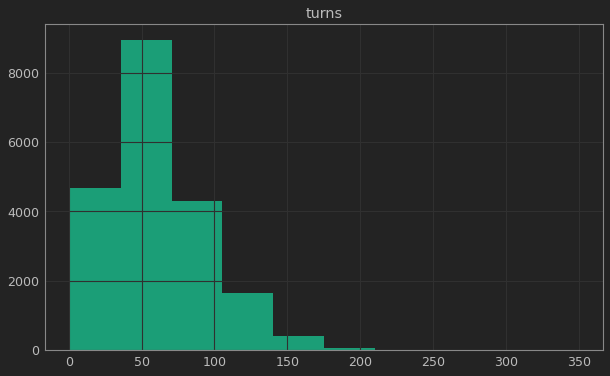

In [131]:
## Explore turns data distribution - we have highly skewed dist of
## games lengths with.
_ = GAMES[['id','turns']].hist(column='turns',figsize=(10,6),color=qual_cmap_4[0])

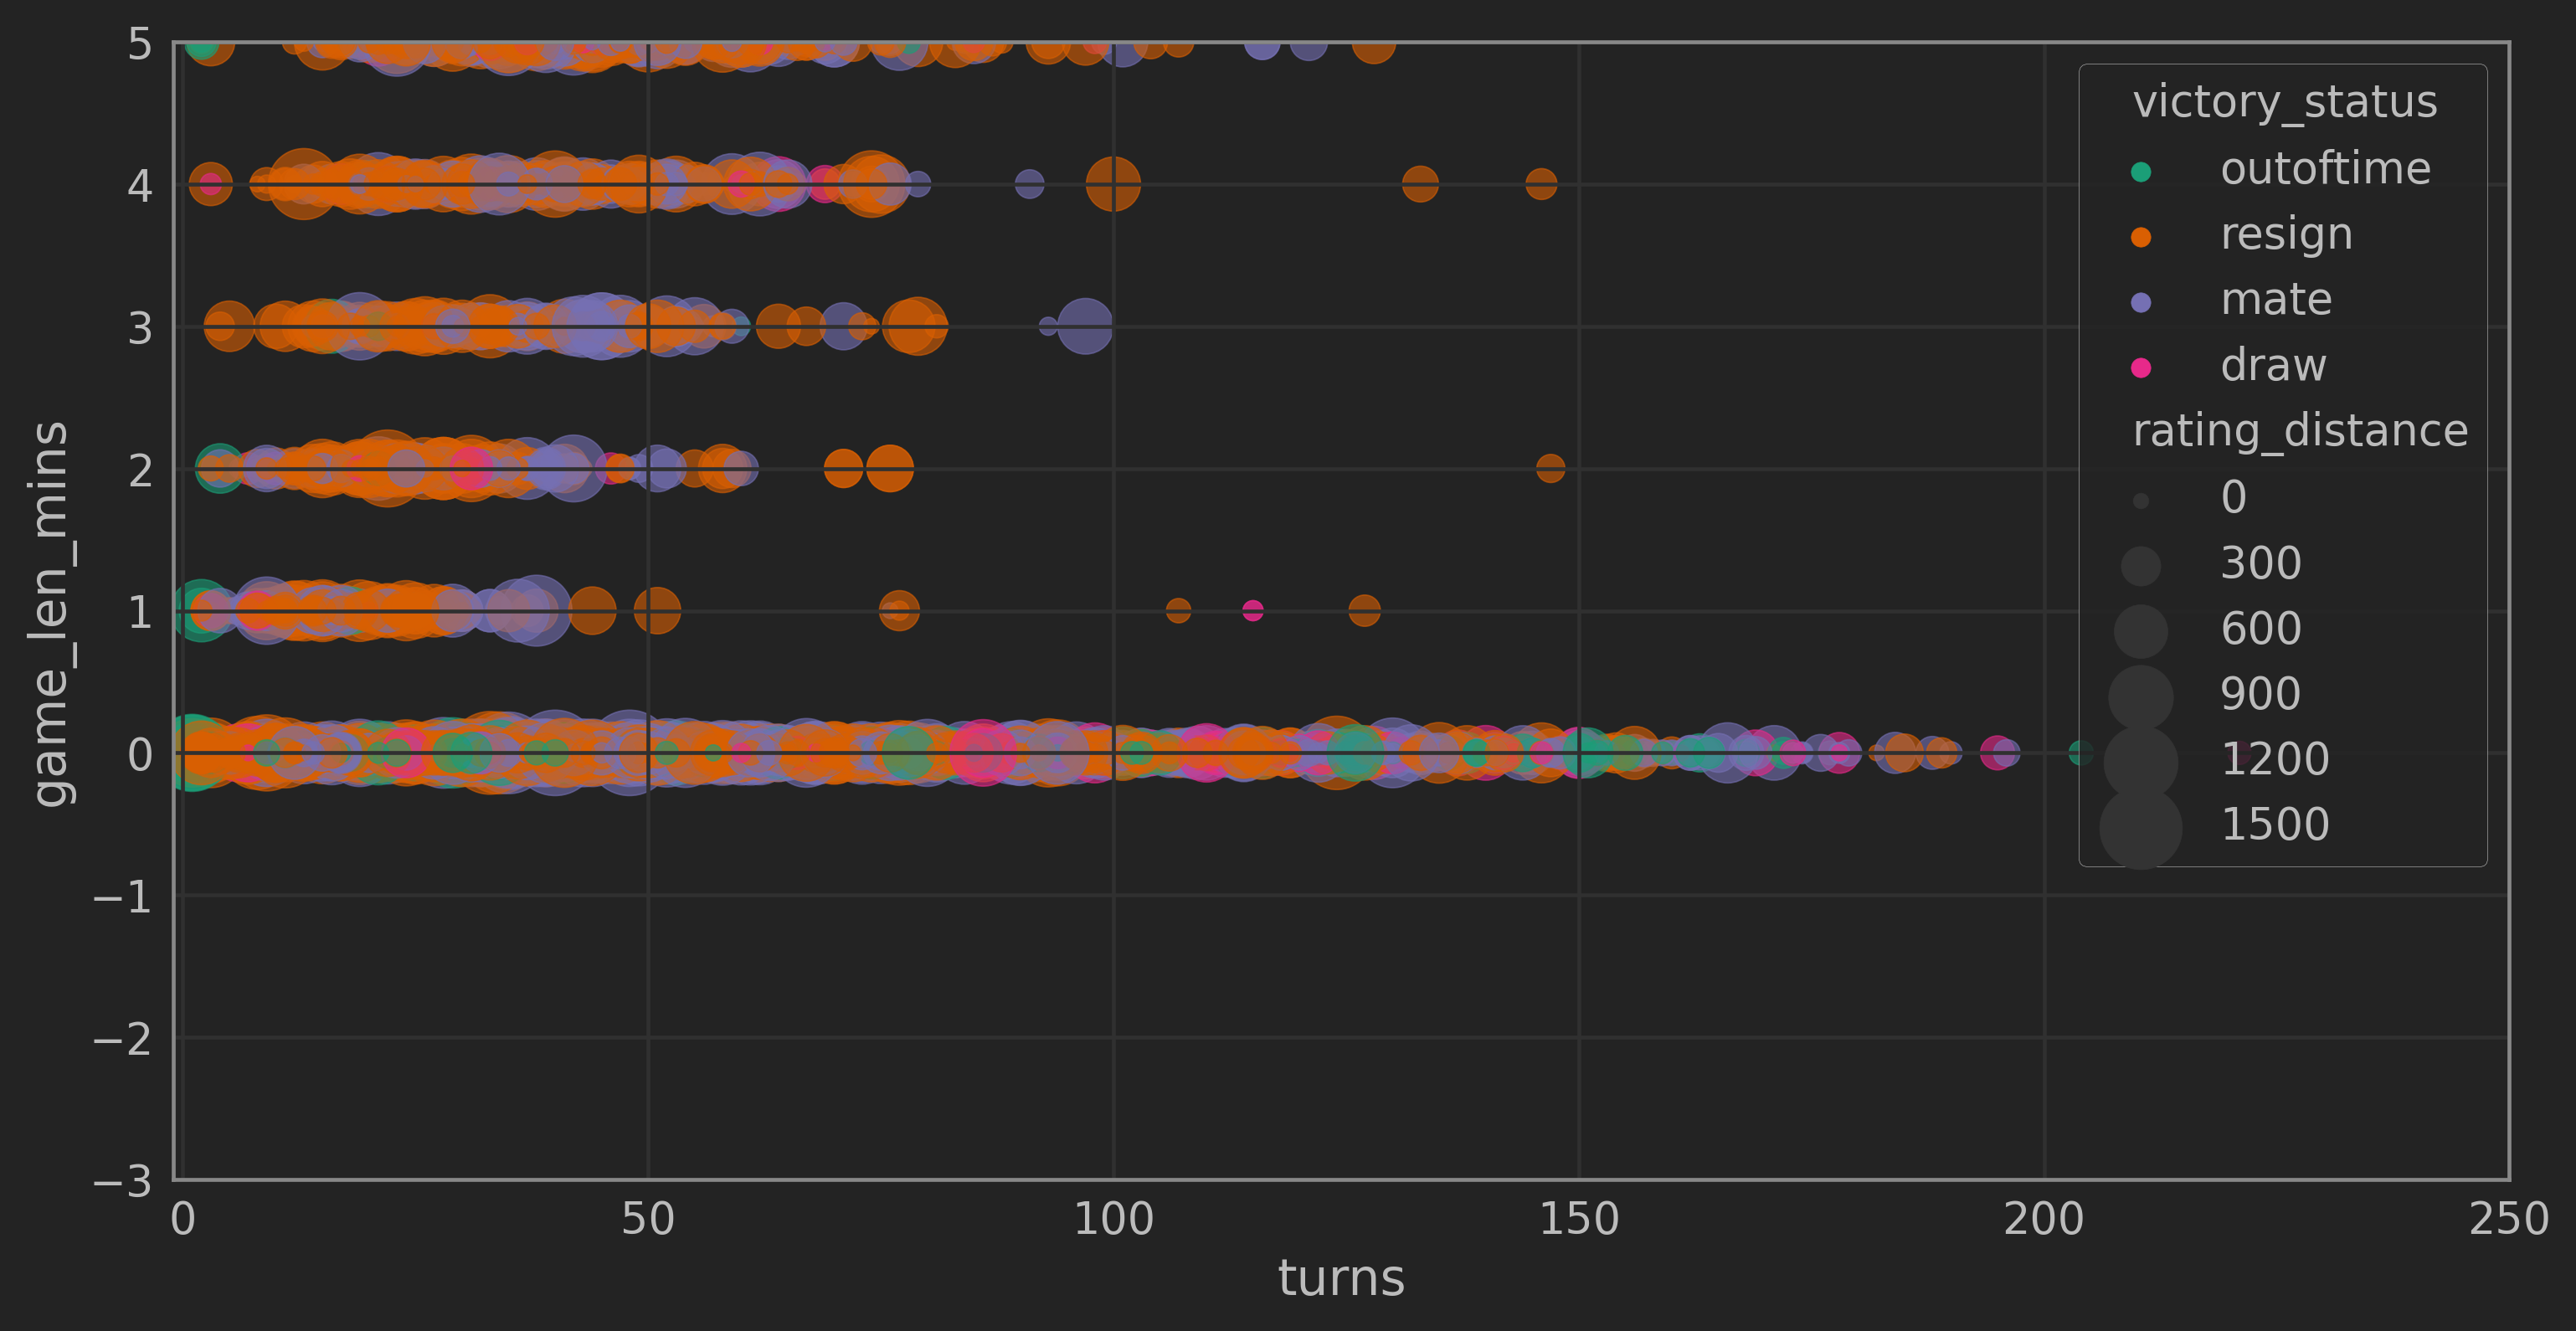

In [188]:
## Explore how points scatter according to length in minutes, number of turns and victory status
plt.figure(figsize=(12,6),dpi=300)

cols_scatter = ['game_len_mins','turns','victory_status','rating_distance']

_ = sns.scatterplot(data=GAMES[cols_scatter],
                    x='turns',
                    y='game_len_mins',
                    hue='victory_status',
                    size='rating_distance',
                    sizes=(20,600),
                    palette=qual_cmap_4,
                    edgecolor=None,
#                     marker='s',
                    s=15,
                    alpha=0.6,
                   legend=True)
_ = plt.xlim((-1,250))
_ = plt.ylim((-3,5))

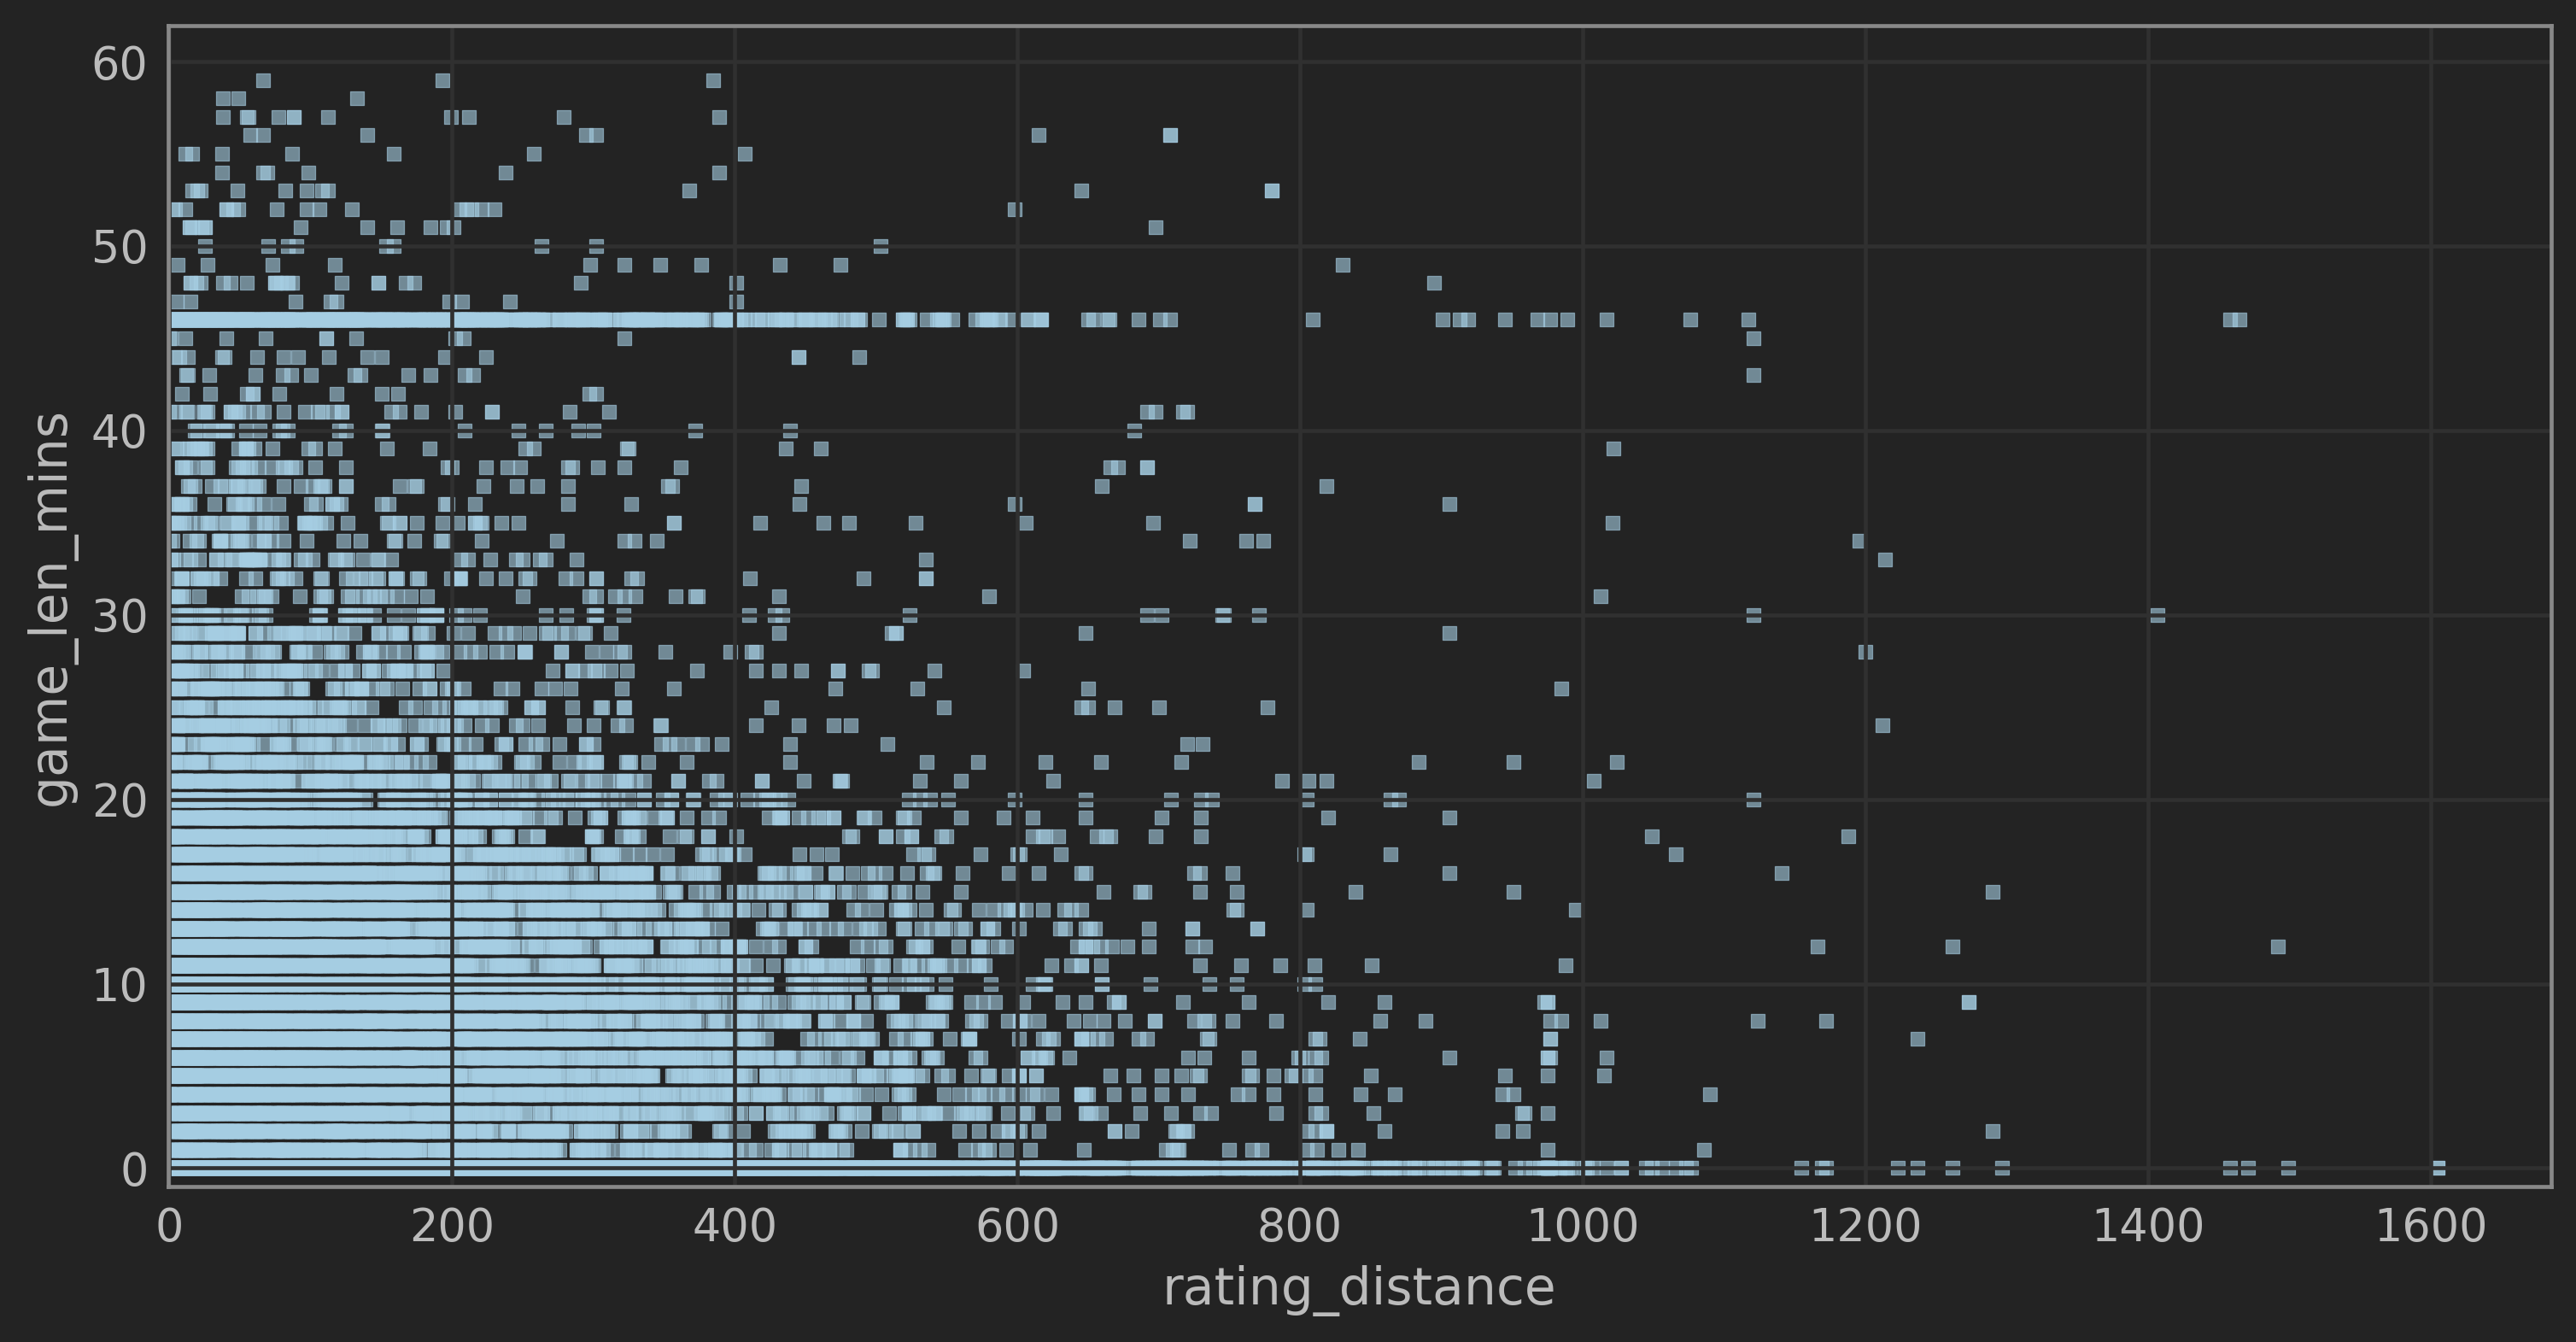

In [159]:
## Explore how points scatter according to length in minutes, number of turns and victory status
plt.figure(figsize=(12,6),dpi=300)

cols_scatter = ['game_len_mins','turns','victory_status','rating_distance']

_ = sns.scatterplot(data=GAMES[cols_scatter],
                    x='rating_distance',
                    y='game_len_mins',
#                     hue='turns',
                    palette='viridis',
                    edgecolor=None,
                    marker='s',
                    s=15,
                    alpha=0.6,
                   legend=True)
_ = plt.xlim(-1)
_ = plt.ylim(-1)

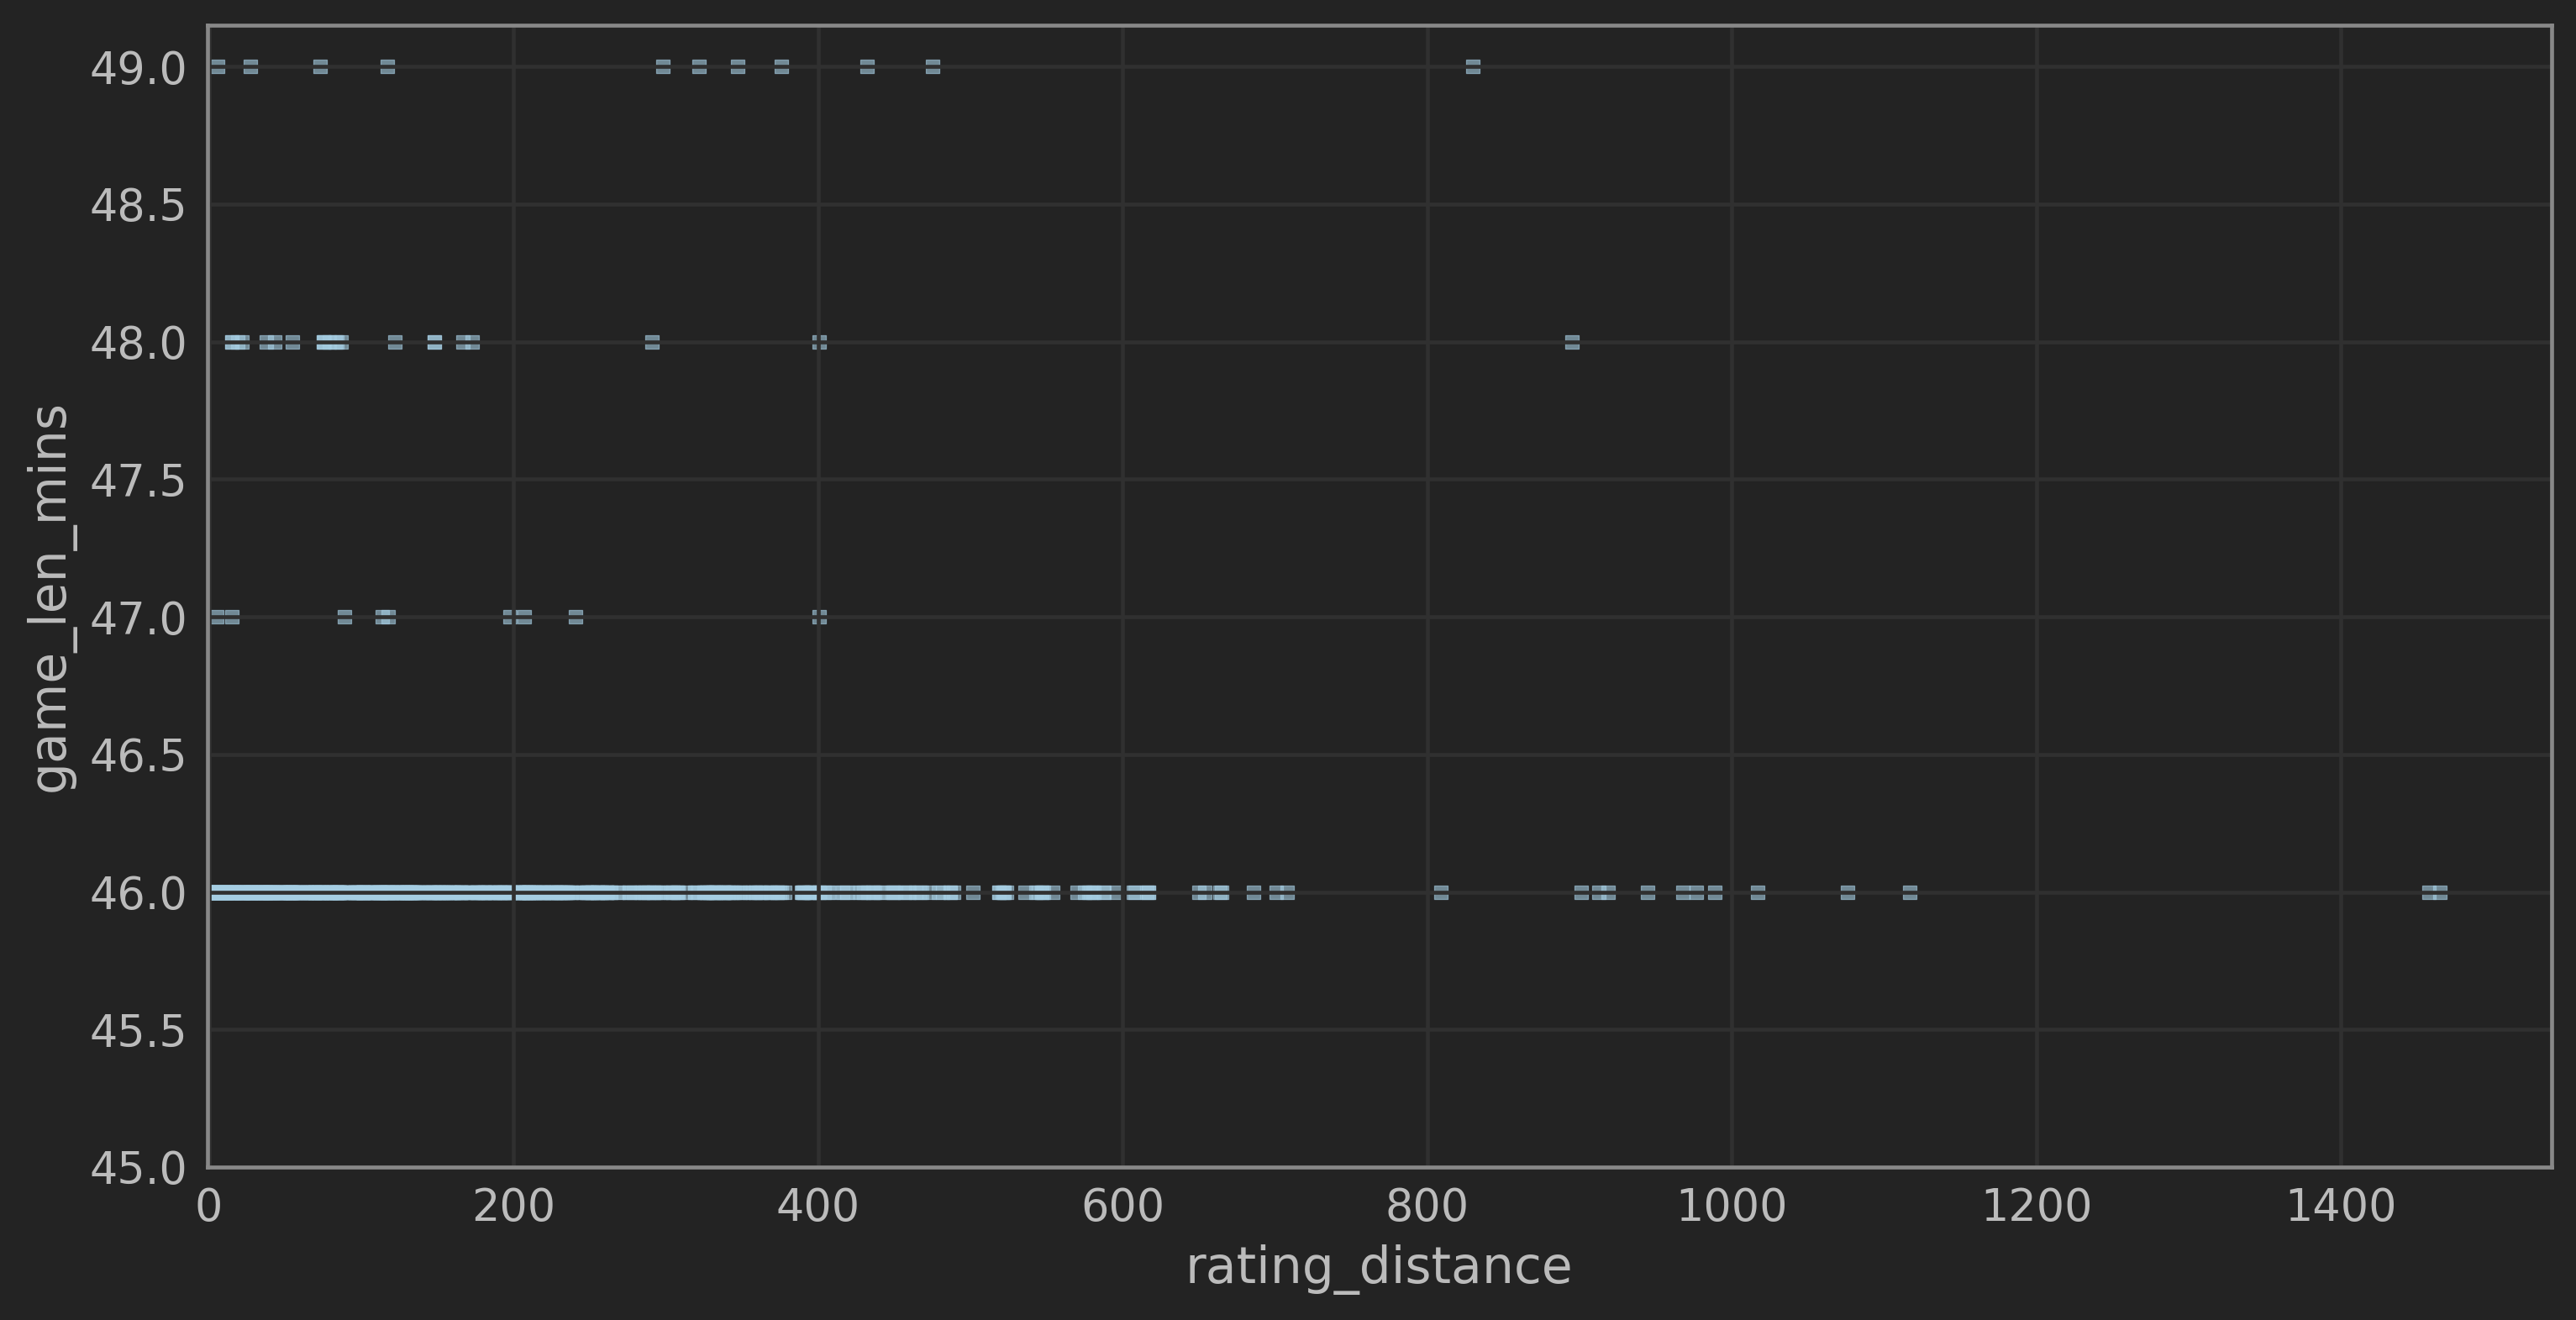

In [165]:
## Explore how points scatter according to length in minutes, number of turns and victory status
plt.figure(figsize=(12,6),dpi=300)

cols_scatter = ['game_len_mins','turns','victory_status','rating_distance']

GAMES_PLT = GAMES[cols_scatter]
GAMES_PLT = GAMES_PLT[(GAMES_PLT['game_len_mins'] > 45) & (GAMES_PLT['game_len_mins'] < 50)]

_ = sns.scatterplot(data=GAMES_PLT,
                    x='rating_distance',
                    y='game_len_mins',
#                     hue='turns',
                    palette='viridis',
                    edgecolor=None,
                    marker='s',
                    s=15,
                    alpha=0.6,
                   legend=True)
_ = plt.xlim(-1)
_ = plt.ylim(45)



## 3. Vector formation

---

### 3.1 Vectorized moves table

In [ ]:
## create a algebraic notation to iccf notation board mapping
# iccf_board = [str(x)+str(y) for x in range(1,9) for y in range(1,9)]
# algebraic_board = [l + str(i) for l in list('abcdefgh') for i in range(1,9)]
# board_mapping = {algebraic : iccf for algebraic, iccf in zip(algebraic_board, iccf_board)}

In [ ]:
## Encode moves into separate variable
GAMES['moves_encoded'] = GAMES['moves'].apply(lambda x: encode_moves(x, 
                                                                     magnitude=10, 
                                                                     encoding='unicode'))

In [ ]:
## Create Moves Table
MOVES = GAMES[['moves_encoded','id']]
MOVES.reset_index(inplace=True, drop=True)

MOVES.head()

In [ ]:
## Form a vector out of moves_encoded variable
MOVES_EXPLODED = MOVES.explode(column='moves_encoded')

In [ ]:
## Construct a list of dataframes representing vectorised games
transposed_moves = move_vectorizer(MOVES_EXPLODED)

In [ ]:
## Concat all vectors into a single dataframe
MOVES_V = pd.concat(transposed_moves)
MOVES_V.fillna(0, inplace=True)

In [ ]:
## Save table for later
MOVES_V.to_csv('./moves_trans.csv')

### 3.1 Vectorized moves table

In [ ]:
## Instantiate One Hot Encoder
ohe = OneHotEncoder(handle_unknown='error')

In [ ]:
## Instantiate Count Vectorizer
cve = CountVectorizer()

In [ ]:
## Set column transformer
column_trans = make_column_transformer((ohe,to_hot_encode),
                                       remainder='passthrough')

In [ ]:
## Fit column transformer
column_trans.fit(GAMES[to_hot_encode])

In [ ]:
## Produce one-hot-encoded array 
hot_array = column_trans.transform(GAMES[to_hot_encode]).toarray()

HOT_ENCODED = pd.DataFrame(hot_array, 
                          columns = column_trans.get_feature_names())

In [ ]:
## Form Meta game table
META = GAMES[num_cols].merge(HOT_ENCODED,
                     left_index=True,
                     right_index=True)

In [ ]:
## Inspect META
META.head()

## UMAP model

---

Parameters:

In [ ]:
distance_metric = 'cosine'
# metrics_available = euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis,
# wminkowski, seuclidean, cosine, correlation, haversine, hamming, jaccard, dice, russelrao, kulsinski,
# ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule

n_neighbors = 20
min_dist = 0.1

Instatiate & train the model:

In [ ]:
## Instantiate UMAP model
reducer = umap.UMAP(metric=distance_metric,
                   n_neighbors=n_neighbors,
                   min_dist=min_dist,
                   n_epochs=500)

In [ ]:
MOVES_V.index.rename('id',inplace=True)

In [ ]:
MOVES_V.reset_index(drop=True, inplace=True)

In [ ]:
MOVES_V.to_csv('./vec.csv')

In [ ]:
## Train the model
embedding = reducer.fit_transform(MOVES_V)

In [ ]:
EMBEDDING_DF = pd.DataFrame(embedding, columns=['x','y'])
EMBEDDING_DF = EMBEDDING_DF.fillna(0)

---

## Plot

---

Parameters:

In [ ]:
## switches
cbar_switch = True

## display
alpha = 0.9
marker_shape = 'o'
marker_size = 4
dpi = 300

## data
cmap_variable = GAMES['turns']

## colors
facecolor = 'black'
labelcolor = 'white'
cmap = 'viridis'

Plot script:

In [ ]:
## Render vis
fig = plt.figure(figsize=(14,12))
fig.patch.set_facecolor(facecolor)

plot = plt.scatter(EMBEDDING_DF['x'], 
                EMBEDDING_DF['y'], 
                marker=marker_shape,
                s=marker_size,
                edgecolor='none',
                c=cmap_variable,
                cmap='viridis', 
                alpha=alpha)

plt.axis("off")
plt.title(f'20k chess games; distance={distance_metric}; nn={n_neighbors}, min=dist={min_dist}\nVECTORISED MOVES - UNICODE CONVERSION', 
          color='w')

if cbar_switch:
    cbar = plt.colorbar(fraction=0.05, 
                    shrink=0.5,
                    ticks=[cmap_variable.min(), 
                    np.quantile(cmap_variable,0.50),
                    np.quantile(cmap_variable,0.75),
                    cmap_variable.max()], alpha=alpha
                           )

    cbar.set_label('embedding Y', color=labelcolor)
    cbar.ax.yaxis.set_tick_params(color=labelcolor)
    cbar.solids.set_edgecolor("face")

plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=labelcolor)

_ = plot

plt.savefig(f"screens/{distance_metric}_nn{n_neighbors}_mind{min_dist}_v{notebook_ver}.png", 
            dpi=dpi, 
            facecolor=facecolor)